In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## IMPORT

In [2]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from collections import Counter
from scipy.stats import skew, kurtosis, entropy
from scipy.special import softmax
from scipy.optimize import minimize

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score, roc_auc_score
)
from xgboost import XGBClassifier

# Imbalanced Learning
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    !pip install imbalanced-learn
    from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

## CONFIGURATION

In [3]:
# 데이터 경로 설정
PATHS = {
    "mon": "/content/drive/MyDrive/Colab Notebooks/25-2 Machine Learning/Team project/mon_standard.pkl",
    "unmon": "/content/drive/MyDrive/Colab Notebooks/25-2 Machine Learning/Team project/unmon_standard10_3000.pkl"
}

In [4]:
CONFIG = {
    'common': {
        'min_seq_length': 10,
        'test_size': 0.2,
        'random_state': 42,
        'n_jobs': -1,
    },

    'closed': {
        'n_monitored_classes': 95,
        'use_website_level': True,
        'corr_th': [1.0, 0.99, 0.98, 0.95, 0.9],
        'rf': {
            'n_estimators': 300,
            'max_depth': 30,
            'max_features': 'log2',
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'random_state': 42,
            'n_jobs': -1,
        },
        'xgb': {
            'n_estimators': 500,
            'min_child_weight': 1,
            'max_depth': 5,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'gamma': 0.1,
            'colsample_bytree': 0.6,
            'random_state': 42,
            'n_jobs': -1,
        }
    },

    'open_binary': {
        'min_seq_length': 10,
        'test_size': 0.2,
        'unmon_label': -1,
        'n_monitored_classes': 95,
        'use_website_level': True,
        'val_size': 0.1,
        'corr_th': [1.0, 0.99, 0.98, 0.95, 0.9],
        'threshold_percentiles': [3.0, 5.0, 7.0, 10.0],
        'main_threshold_percentile': 5.0,
        'n_splits_cv': 5,
        'rf': {
            'n_estimators': 500,
            'max_depth': 20,
            'min_samples_split': 5,
            'class_weight': 'balanced',
            'random_state': 42,
            'n_jobs': -1,
        },
        'xgb': {
            'n_estimators': 400,
            'max_depth': 9,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 1.0,
            'tree_method': 'hist',
            'eval_metric': 'mlogloss',
            'random_state': 42,
            'n_jobs': -1,
        }
    },

    'open_multi': {
        'unmon_label': -1,
        'n_monitored_classes': 95,
        'use_website_level': True,
        'val_size': 0.1,
        'corr_th': [1.0, 0.99, 0.98, 0.95, 0.9],
        'threshold_percentiles': [10.0, 15.0, 20.0, 25.0, 30.0],
        'main_threshold_percentile': 5.0,
        'n_splits_cv': 5,
        'rf': {
            'n_estimators': 500,
            'max_depth': 20,
            'min_samples_split': 5,
            'min_samples_leaf': 1,
            'class_weight': 'balanced',
            'random_state': 42,
            'n_jobs': -1,
        },
        'xgb': {
            'n_estimators': 400,
            'max_depth': 9,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 1.0,
            'tree_method': 'hist',
            'eval_metric': 'mlogloss',
            'enable_categorical': False,
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': 0,
        }
    }
}

In [5]:
# 시나리오 선택
SCENARIO = 'open_multi'  # 'closed', 'open_binary', 'open_multi'
CURRENT_CONFIG = {**CONFIG['common'], **CONFIG[SCENARIO]}

## Feature Extraction

In [6]:
def get_feature_names_base():
    return [
        "Total_Packets", "Num_Outgoing", "Num_Incoming", "Fraction_Incoming", "Fraction_Outgoing",
        "Mean_Size", "Std_Size", "Median_Size", "Max_Size", "Min_Size",
        "Skew_Size", "Kurt_Size", "Mean_Incoming_Size", "Mean_Outgoing_Size",
        "Total_Incoming_Bytes", "Total_Outgoing_Bytes",
        "Num_Bursts", "Mean_Burst_Length", "Std_Burst_Length", "Max_Burst_Length",
        "Mean_Burst_Size", "Max_Burst_Size",
        "CumNorm_Mean", "CumNorm_Std", "Max_Cumulative", "Min_Cumulative",
        "Total_Duration", "Mean_Inter_Time", "Std_Inter_Time", "Max_Inter_Time",
        "Packet_Rate", "Incoming_Rate", "Outgoing_Rate",
        "IAT_Out_Mean", "IAT_Out_Std", "IAT_Out_25th", "IAT_Out_75th",
        "Corr_Time_Size", "AutoCorr_Mean", "Interval_Mean", "Interval_Std",
        "First_30_Outgoing", "First_30_Incoming", "Last_30_Outgoing", "Last_30_Incoming",
        "Packets_First_Second", "Packets_Last_Second",
        "Size_25th", "Size_75th", "Size_IQR",
        "Direction_Entropy", "Size_Bin_Entropy", "Burst_Direction_Entropy", "IAT_Bin_Entropy"
    ]

In [7]:
def extract_features_final(trace: dict) -> dict:
    ts = np.array(trace["timestamp"], dtype=float)
    sz = np.array(trace["size"], dtype=float)
    if len(ts) > 1:
        idx = np.argsort(ts)
        ts, sz = ts[idx], sz[idx]
    n = len(sz)
    if n == 0: return {k: 0.0 for k in get_feature_names_base()}

    feats = {}
    abs_sz = np.abs(sz)

    # 1) Basic / Direction Features
    out_mask = sz > 0
    in_mask = sz < 0
    n_out = np.sum(out_mask)
    n_in = np.sum(in_mask)

    feats["Total_Packets"] = n
    feats["Num_Outgoing"] = int(n_out)
    feats["Num_Incoming"] = int(n_in)
    feats["Fraction_Incoming"] = n_in / n if n > 0 else 0.0
    feats["Fraction_Outgoing"] = n_out / n if n > 0 else 0.0

    # 2) Size Statistics
    feats["Mean_Size"] = float(np.mean(sz))
    feats["Std_Size"] = float(np.std(sz))
    feats["Median_Size"] = float(np.median(sz))
    feats["Max_Size"] = float(np.max(sz))
    feats["Min_Size"] = float(np.min(sz))
    feats["Skew_Size"] = float(skew(sz)) if n > 1 else 0.0
    feats["Kurt_Size"] = float(kurtosis(sz)) if n > 1 else 0.0

    # Incoming/Outgoing splits
    in_sz = abs_sz[in_mask]
    out_sz = sz[out_mask]
    feats["Mean_Incoming_Size"] = float(np.mean(in_sz)) if len(in_sz) > 0 else 0.0
    feats["Mean_Outgoing_Size"] = float(np.mean(out_sz)) if len(out_sz) > 0 else 0.0
    feats["Total_Incoming_Bytes"] = float(np.sum(in_sz))
    feats["Total_Outgoing_Bytes"] = float(np.sum(out_sz))

    # 3) Burst Features
    bursts = []
    burst_directions = []
    if n > 0:
        cur_dir = np.sign(sz[0])
        cur_len = 1
        cur_sum = abs(sz[0])
        for i in range(1, n):
            d = np.sign(sz[i])
            if d == cur_dir:
                cur_len += 1
                cur_sum += abs(sz[i])
            else:
                bursts.append({"length": cur_len, "size": cur_sum})
                burst_directions.append(cur_dir)
                cur_dir = d
                cur_len = 1
                cur_sum = abs(sz[i])
        bursts.append({"length": cur_len, "size": cur_sum})
        burst_directions.append(cur_dir)

    if bursts:
        b_len = np.array([b["length"] for b in bursts])
        b_sz = np.array([b["size"] for b in bursts])
        feats["Num_Bursts"] = len(bursts)
        feats["Mean_Burst_Length"] = float(np.mean(b_len))
        feats["Std_Burst_Length"] = float(np.std(b_len))
        feats["Max_Burst_Length"] = float(np.max(b_len))
        feats["Mean_Burst_Size"] = float(np.mean(b_sz))
        feats["Max_Burst_Size"] = float(np.max(b_sz))
    else:
        feats["Num_Bursts"] = 0
        feats["Mean_Burst_Length"] = 0.0
        feats["Std_Burst_Length"] = 0.0
        feats["Max_Burst_Length"] = 0.0
        feats["Mean_Burst_Size"] = 0.0
        feats["Max_Burst_Size"] = 0.0

    # 4) Normalized Cumulative Stats
    cum = np.cumsum(sz)
    max_abs_cum = np.max(np.abs(cum)) if np.max(np.abs(cum)) != 0 else 1.0
    cum_norm = cum / max_abs_cum

    feats["CumNorm_Mean"] = float(np.mean(cum_norm))
    feats["CumNorm_Std"] = float(np.std(cum_norm))
    feats["Max_Cumulative"] = float(np.max(cum))
    feats["Min_Cumulative"] = float(np.min(cum))

    # 5) Time-based Features
    if n > 1:
        duration = ts[-1] - ts[0]
        feats["Total_Duration"] = duration if duration > 0 else 0.0

        inter = np.diff(ts)
        inter = inter[inter > 0]
        feats["Mean_Inter_Time"] = float(np.mean(inter)) if len(inter) > 0 else 0.0
        feats["Std_Inter_Time"] = float(np.std(inter)) if len(inter) > 0 else 0.0
        feats["Max_Inter_Time"] = float(np.max(inter)) if len(inter) > 0 else 0.0

        feats["Packet_Rate"] = n / duration if duration > 0 else 0.0
        feats["Incoming_Rate"] = n_in / duration if duration > 0 else 0.0
        feats["Outgoing_Rate"] = n_out / duration if duration > 0 else 0.0
    else:
        feats["Total_Duration"] = 0.0
        feats["Mean_Inter_Time"] = 0.0
        feats["Std_Inter_Time"] = 0.0
        feats["Max_Inter_Time"] = 0.0
        feats["Packet_Rate"] = 0.0
        feats["Incoming_Rate"] = 0.0
        feats["Outgoing_Rate"] = 0.0

    # Outgoing-only IAT
    out_idx = np.where(sz > 0)[0]
    if len(out_idx) > 1:
        t_out = np.sort(ts[out_idx])
        iat_out = np.diff(t_out)
        iat_out = iat_out[iat_out > 0]
        feats["IAT_Out_Mean"] = float(np.mean(iat_out)) if len(iat_out) > 0 else 0.0
        feats["IAT_Out_Std"] = float(np.std(iat_out)) if len(iat_out) > 0 else 0.0
        feats["IAT_Out_25th"] = float(np.percentile(iat_out, 25)) if len(iat_out) > 0 else 0.0
        feats["IAT_Out_75th"] = float(np.percentile(iat_out, 75)) if len(iat_out) > 0 else 0.0
    else:
        feats["IAT_Out_Mean"] = 0.0
        feats["IAT_Out_Std"] = 0.0
        feats["IAT_Out_25th"] = 0.0
        feats["IAT_Out_75th"] = 0.0

    # 6) Correlation Features
    if np.std(ts) > 0 and np.std(sz) > 0:
        feats["Corr_Time_Size"] = float(np.corrcoef(ts, sz)[0, 1])
    else:
        feats["Corr_Time_Size"] = 0.0

    # Autocorrelation 1~4
    ac_vals = []
    for lag in range(1, min(5, n // 2)):
        s1, s2 = sz[:-lag], sz[lag:]
        if np.std(s1) > 0 and np.std(s2) > 0:
            ac_vals.append(np.corrcoef(s1, s2)[0, 1])
    feats["AutoCorr_Mean"] = float(np.mean(ac_vals)) if ac_vals else 0.0

    # 7) Interval-based Features
    if feats.get("Total_Duration", 0) > 0:
        N = 5
        bins = np.linspace(ts[0], ts[-1], N + 1)
        sums = []
        for i in range(N):
            idx = np.where((ts >= bins[i]) & (ts < bins[i + 1]))[0]
            sums.append(float(np.sum(abs_sz[idx])))

        feats["Interval_Mean"] = float(np.mean(sums))
        feats["Interval_Std"] = float(np.std(sums))
    else:
        feats["Interval_Mean"] = 0.0
        feats["Interval_Std"] = 0.0

    # 8) Position-based Features
    K = min(30, n)
    first = sz[:K]
    last = sz[-K:]

    feats["First_30_Outgoing"] = int(np.sum(first > 0))
    feats["First_30_Incoming"] = int(np.sum(first < 0))
    feats["Last_30_Outgoing"] = int(np.sum(last > 0))
    feats["Last_30_Incoming"] = int(np.sum(last < 0))

    feats["Packets_First_Second"] = int(np.sum(ts <= (ts[0] + 1.0)))
    feats["Packets_Last_Second"] = int(np.sum(ts >= (ts[-1] - 1.0)))

    # 9) Percentile Features
    feats["Size_25th"] = float(np.percentile(sz, 25))
    feats["Size_75th"] = float(np.percentile(sz, 75))
    feats["Size_IQR"] = feats["Size_75th"] - feats["Size_25th"]

    # 10) ENTROPY FEATURES
    from collections import Counter

    def safe_entropy(values):
        if len(values) == 0:
            return 0.0
        counts = Counter(values)
        probs = np.array(list(counts.values())) / len(values)
        return float(entropy(probs))

    # 10-1) Direction Entropy
    directions = np.sign(sz)
    directions = directions[directions != 0]
    feats["Direction_Entropy"] = safe_entropy(directions)

    # 10-2) Size Bin Entropy
    if n > 0:
        n_bins = 20
        size_bins = np.digitize(abs_sz, bins=np.linspace(0, 512, n_bins + 1))
        feats["Size_Bin_Entropy"] = safe_entropy(size_bins)
    else:
        feats["Size_Bin_Entropy"] = 0.0

    # 10-3) Burst Direction Entropy
    if len(burst_directions) > 0:
        feats["Burst_Direction_Entropy"] = safe_entropy(burst_directions)
    else:
        feats["Burst_Direction_Entropy"] = 0.0

    # 10-4) IAT Bin Entropy
    if len(inter) > 0 and feats.get("Total_Duration", 0) > 0:
        iat_normalized = inter / feats["Total_Duration"]
        iat_bins = np.digitize(iat_normalized, bins=np.linspace(0, 1, 11))
        feats["IAT_Bin_Entropy"] = safe_entropy(iat_bins)
    else:
        feats["IAT_Bin_Entropy"] = 0.0

    feats["label"] = trace["label"]

    return feats

## Data Loading

In [8]:
def load_dataset():
    print(">>> Loading Data...")
    if 'PATHS' not in globals(): raise NameError("PATHS not defined.")
    with open(PATHS['mon'], 'rb') as f: mon_data = pickle.load(f)

    traces = []
    if isinstance(mon_data, dict):
        for cls_id, samples in mon_data.items():
            if SCENARIO == 'closed' and cls_id >= 950: continue
            label = int(cls_id)//10 if CURRENT_CONFIG.get('use_website_level') else int(cls_id)

            for s in samples:
                if len(s) < CURRENT_CONFIG['min_seq_length']: continue
                traces.append({"timestamp": np.abs(np.array(s)), "size": np.sign(np.array(s))*512, "label": label})

    if SCENARIO != 'closed':
        with open(PATHS['unmon'], 'rb') as f: unmon_data = pickle.load(f)
        for s in unmon_data:
            if len(s) < CURRENT_CONFIG['min_seq_length']: continue
            traces.append({"timestamp": np.abs(np.array(s)), "size": np.sign(np.array(s))*512, "label": CURRENT_CONFIG['unmon_label']})

    return traces

In [9]:
# Execution
all_traces = load_dataset()
print(f"Total Traces: {len(all_traces)}")

df_list = []
for t in tqdm(all_traces, desc="Extracting Features"):
    df_list.append(extract_features_final(t))
df_all = pd.DataFrame(df_list).fillna(0)
X = df_all.drop(columns=['label'])
y = df_all['label'].values
print(f"Feature Extraction Done. Shape: {X.shape}")

>>> Loading Data...
Total Traces: 22000


Extracting Features:   0%|          | 0/22000 [00:00<?, ?it/s]

Feature Extraction Done. Shape: (22000, 54)


## Preprocessing Classes

In [10]:
class CustomLabelEncoder:
    """XGBoost용 (-1 라벨 처리 및 복원)"""
    def __init__(self):
        self.mapper = {}
        self.inv_mapper = {}
    def fit(self, y):
        uniques = sorted(np.unique(y))
        self.mapper = {v: i for i, v in enumerate(uniques)}
        self.inv_mapper = {i: v for i, v in enumerate(uniques)}
        return self
    def transform(self, y):
        return np.array([self.mapper.get(v, -1) for v in y])
    def inverse_transform(self, y_enc):
        return np.array([self.inv_mapper.get(v, -1) for v in y_enc])
    def fit_transform(self, y):
        self.fit(y)
        return self.transform(y)

In [11]:
class EnhancedPreprocessor:
    """
    Correlation threshold + StandardScaler
    sklearn Pipeline 호환을 위해 타입 검증 완화
    """
    def __init__(self, correlation_threshold):
        try:
            self.correlation_threshold = float(correlation_threshold)
        except (TypeError, ValueError) as e:
            raise TypeError(
                f"correlation_threshold must be numeric, got {type(correlation_threshold).__name__}"
            ) from e

        if not (0 <= self.correlation_threshold <= 1):
            raise ValueError(
                f"correlation_threshold must be in [0,1], got {self.correlation_threshold}"
            )

        self.scaler = StandardScaler()
        self.features_to_drop = []
        self.feature_names = None

    def fit(self, X_train: pd.DataFrame):
        # 1. Correlation-based removal
        corr_matrix = X_train.corr().abs()
        upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        self.features_to_drop = [
            col for col in upper.columns
            if any(upper[col] > self.correlation_threshold)
        ]

        # 2. Remove correlated features
        X_reduced = X_train.drop(columns=self.features_to_drop)
        self.feature_names = X_reduced.columns.tolist()

        # 3. Fit scaler
        self.scaler.fit(X_reduced)

        # 4. Print info
        print(f"   [EnhancedPreprocessor] Correlation threshold: {self.correlation_threshold}")
        print(f"   [EnhancedPreprocessor] Removed {len(self.features_to_drop)} features")
        print(f"   [EnhancedPreprocessor] Final: {len(self.feature_names)} features")

        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        # Drop features that were removed during fit
        X_reduced = X.drop(columns=[c for c in self.features_to_drop if c in X.columns])
        return self.scaler.transform(X_reduced[self.feature_names])

    def fit_transform(self, X_train: pd.DataFrame) -> np.ndarray:
        self.fit(X_train)
        return self.transform(X_train)

In [12]:
class CorrPreprocessor:
    """[Open World 전용] Simple Correlation Removal + Scaling"""
    def __init__(self, correlation_threshold=0.98):
        self.correlation_threshold = correlation_threshold
        self.scaler = StandardScaler()
        self.features_to_drop = []
        self.feature_names = None

    def fit(self, X):
        corr = X.corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        self.features_to_drop = [c for c in upper.columns if any(upper[c] > self.correlation_threshold)]
        X_reduced = X.drop(columns=self.features_to_drop)
        self.feature_names = X_reduced.columns.tolist()
        self.scaler.fit(X_reduced)
        print(f"  [CorrPrep] Dropped {len(self.features_to_drop)} features (Th={self.correlation_threshold})")
        return self

    def transform(self, X):
        X_reduced = X.drop(columns=[c for c in self.features_to_drop if c in X.columns])
        return self.scaler.transform(X_reduced[self.feature_names])

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [13]:
class TemperatureScaler:
    """Probability Calibration for OSR"""
    def __init__(self):
        self.T = 1.0
    def fit(self, logits, y_idx):
        def nll(T_arr):
            scaled = logits / T_arr[0]
            probs = softmax(scaled, axis=1)
            n = probs.shape[0]
            p = probs[np.arange(n), y_idx]
            return float(-np.log(p + 1e-12).mean())
        res = minimize(nll, x0=np.array([1.0]), bounds=[(0.1, 10.0)], method='L-BFGS-B')
        self.T = float(res.x[0])
        return self
    def transform(self, logits):
        return softmax(logits / self.T, axis=1)

## Training & Evaluation Logic

In [14]:
def evaluate_open_world(y_true, y_pred, y_proba, unmon_label=-1, scenario='None'):
    print(f"\n{'='*70}")
    print(f"  EVALUATION ({scenario.upper()})")
    print(f"{'='*70}")

    # 기본 메트릭 초기화
    tpr = fpr = tnr = precision = recall = roc_auc = pr_auc = 0.0
    mon_acc = mon_f1 = 0.0

    ## 1. Overall Performance (모든 시나리오 공통)
    overall_acc = accuracy_score(y_true, y_pred)
    overall_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    ## 2. Open-World 전용 메트릭 계산
    if scenario != 'closed':
        # Binary Classification Performance
        y_binary_true = (y_true != unmon_label).astype(int)
        y_binary_pred = (y_pred != unmon_label).astype(int)

        # Masks for actual classes
        monitored_mask = (y_true != unmon_label)
        unmonitored_mask = (y_true == unmon_label)

        # TPR: True Positive Rate (실제 monitored 중 monitored로 예측)
        tpr = (y_binary_pred[monitored_mask] == 1).sum() / monitored_mask.sum() if monitored_mask.sum() > 0 else 0.0

        # FPR: False Positive Rate (실제 unmonitored 중 monitored로 오예측)
        fpr = (y_binary_pred[unmonitored_mask] == 1).sum() / unmonitored_mask.sum() if unmonitored_mask.sum() > 0 else 0.0

        # TNR: True Negative Rate
        tnr = 1 - fpr

        # Precision & Recall
        precision = precision_score(y_binary_true, y_binary_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_binary_true, y_binary_pred, pos_label=1, zero_division=0)

        # Confidence scores 계산
        if scenario == 'open_binary':
            # Binary: monitored 클래스 확률
            if y_proba.shape[1] == 2:
                confidence_scores = y_proba[:, 1]
            else:
                confidence_scores = y_proba[:, 0]
        else:  # open_multi
            # Multi-class: 최대 확률
            confidence_scores = np.max(y_proba, axis=1)

        # ROC-AUC
        try:
            roc_auc = roc_auc_score(y_binary_true, confidence_scores)
        except ValueError as e:
            roc_auc = 0.0
            print(f"  [Warning] ROC-AUC calculation failed: {e}")

        # PR-AUC
        try:
            pr_auc = average_precision_score(y_binary_true, confidence_scores)
        except ValueError as e:
            pr_auc = 0.0
            print(f"  [Warning] PR-AUC calculation failed: {e}")

        # Binary Detection 결과 출력
        print(f"\n[Binary Detection: Monitored vs Unmonitored]")
        print(f"  TPR (True Positive Rate / Recall): {tpr:.4f}")
        print(f"  FPR (False Positive Rate): {fpr:.4f}")
        print(f"  TNR (True Negative Rate): {tnr:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  ROC-AUC: {roc_auc:.4f}")
        print(f"  PR-AUC: {pr_auc:.4f}")

        # Monitored-only Performance
        mon_mask = (y_true != unmon_label) & (y_pred != unmon_label)

        if mon_mask.sum() > 0:
            mon_acc = accuracy_score(y_true[mon_mask], y_pred[mon_mask])
            mon_f1 = f1_score(y_true[mon_mask], y_pred[mon_mask], average='macro', zero_division=0)

    ## 3. Overall Performance 출력 (모든 시나리오)
    print(f"\n[Overall Performance]")
    print(f"  Overall Accuracy: {overall_acc:.4f}")
    print(f"  Overall Macro F1: {overall_f1:.4f}")

    ## 4. Monitored 성능 출력 (Open-World만)
    if scenario != 'closed':
        if mon_mask.sum() > 0:
            if scenario == 'open_multi':
                print(f"\n[Monitored 95-Class Performance]")
                print(f"  Accuracy (among detected monitored): {mon_acc:.4f}")
                print(f"  Macro F1 (among monitored): {mon_f1:.4f}")
            elif scenario == 'open_binary':
                print(f"\n[Monitored Class Performance]")
                print(f"  Accuracy (among detected monitored): {mon_acc:.4f}")
                print(f"  Macro F1 (among monitored): {mon_f1:.4f}")
        else:
            print(f"\n[Monitored Performance]")
            print(f"  No samples predicted as monitored")

    print(f"{'='*70}\n")

    ## Return metrics
    return {
        'TPR': tpr,
        'FPR': fpr,
        'Precision': precision,
        'Recall': recall,
        'ROC_AUC': roc_auc,
        'PR_AUC': pr_auc,
        'TNR': tnr,
        'overall_acc': overall_acc,
        'overall_f1': overall_f1,
        'monitored_acc': mon_acc,
        'monitored_f1': mon_f1
    }

In [15]:
def train_model_wrapper(algo, X_tr, y_tr, X_te, y_te, params, unmon_label=-1):
    """모델 학습 및 평가"""
    p = params.copy()
    if 'corr_th' in p: del p['corr_th']

    if algo == 'rf':
        clf = RandomForestClassifier(n_jobs=-1, random_state=42, **p)
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)
        y_proba = clf.predict_proba(X_te)

    elif algo == 'xgb':
        # Label Encoding for XGBoost
        le = CustomLabelEncoder()
        y_tr_enc = le.fit_transform(y_tr)

        clf = XGBClassifier(
            n_estimators=p['n_estimators'],
            max_depth=p['max_depth'],
            learning_rate=p['learning_rate'],
            subsample=p.get('subsample', 0.8),
            colsample_bytree=p.get('colsample_bytree', 0.8),
            objective='multi:softprob',
            num_class=len(le.mapper),
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=42
        )
        clf.fit(X_tr, y_tr_enc)

        y_pred_enc = clf.predict(X_te)
        y_pred = le.inverse_transform(y_pred_enc)
        y_proba = clf.predict_proba(X_te)

    else:
        raise ValueError(f"Unknown algorithm: {algo}")

    # Basic metrics
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average='macro')

    print(f"\n[{algo.upper()}] Basic Metrics:")
    print(f"  Overall Accuracy: {acc:.4f}")
    print(f"  Macro F1-Score: {f1:.4f}")

    # Open-World Detailed Evaluation
    detailed_metrics = evaluate_open_world(y_te, y_pred, y_proba, unmon_label)

    return clf, {
        'accuracy': acc,
        'f1_macro': f1,
        'y_pred': y_pred,
        'y_proba': y_proba,
        **detailed_metrics
    }

In [16]:
def calculate_class_weights(y: np.ndarray):
    """클래스 가중치 계산 (불균형 처리)"""
    from collections import Counter
    cnt = Counter(y)
    n = len(y)
    c = len(cnt)
    return {cls: n / (c * cnt[cls]) for cls in cnt.keys()}

## MAIN: CLOSED & OPEN WORLD

In [17]:
if SCENARIO == 'closed':
    ## CLOSED WORLD
    print("\n" + "="*80)
    print(" CLOSED WORLD SCENARIO")
    print("="*80)

    results_closed = []
    for corr_th in CURRENT_CONFIG['corr_th']:
        print(f"\n[Closed] Testing with Correlation Threshold: {corr_th}")

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=CURRENT_CONFIG['test_size'],
            random_state=CURRENT_CONFIG['random_state'],
            stratify=y
        )

        prep = EnhancedPreprocessor(correlation_threshold=corr_th)
        X_train_prep = prep.fit_transform(X_train)
        X_test_prep = prep.transform(X_test)

        # RF Training
        print("\n[RF Training]")
        rf_model = RandomForestClassifier(**CURRENT_CONFIG['rf'])
        rf_model.fit(X_train_prep, y_train)
        rf_pred = rf_model.predict(X_test_prep)
        rf_acc = accuracy_score(y_test, rf_pred)
        rf_f1 = f1_score(y_test, rf_pred, average='macro')
        print(f"  RF Accuracy: {rf_acc:.4f}")
        print(f"  RF Macro F1: {rf_f1:.4f}")

        # XGB Training
        print("\n[XGB Training]")
        le = CustomLabelEncoder()
        y_train_enc = le.fit_transform(y_train)

        xgb_model = XGBClassifier(
            objective='multi:softprob',
            num_class=len(le.mapper),
            use_label_encoder=False,
            **CURRENT_CONFIG['xgb']
        )
        xgb_model.fit(X_train_prep, y_train_enc)
        xgb_pred_enc = xgb_model.predict(X_test_prep)
        xgb_pred = le.inverse_transform(xgb_pred_enc)
        xgb_acc = accuracy_score(y_test, xgb_pred)
        xgb_f1 = f1_score(y_test, xgb_pred, average='macro')
        print(f"  XGB Accuracy: {xgb_acc:.4f}")
        print(f"  XGB Macro F1: {xgb_f1:.4f}")

        results_closed.append({
            'corr_th': corr_th,
            'rf_acc': rf_acc,
            'rf_f1': rf_f1,
            'xgb_acc': xgb_acc,
            'xgb_f1': xgb_f1
        })

    df_closed = pd.DataFrame(results_closed)
    print("\n" + "="*80)
    print("[Closed World Results Summary]")
    print("="*80)
    print(df_closed)


elif SCENARIO == 'open_binary':
    ## OPEN-WORLD BINARY CLASSIFICATION
    print("\n" + "="*80)
    print(" OPEN-WORLD BINARY CLASSIFICATION SCENARIO")
    print("="*80)

    # Binary label 생성: Monitored=1, Unmonitored=-1
    y_binary = np.where(y == CURRENT_CONFIG['unmon_label'], -1, 1)
    print(f"  Monitored samples (label=1): {np.sum(y_binary == 1)}")
    print(f"  Unmonitored samples (label=-1): {np.sum(y_binary == -1)}")

    results_binary = []

    for corr_th in CURRENT_CONFIG['corr_th']:
        print(f"\n[Binary] Testing with Correlation Threshold: {corr_th}")

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_binary,
            test_size=CURRENT_CONFIG['test_size'],
            random_state=CURRENT_CONFIG['random_state'],
            stratify=y_binary
        )

        prep = EnhancedPreprocessor(correlation_threshold=corr_th)
        X_train_prep = prep.fit_transform(X_train)
        X_test_prep = prep.transform(X_test)

        ## RF Binary Classification
        print("\n[RF Binary Classification]")
        rf_model = RandomForestClassifier(**CURRENT_CONFIG['rf'])
        rf_model.fit(X_train_prep, y_train)
        rf_pred = rf_model.predict(X_test_prep)
        rf_proba = rf_model.predict_proba(X_test_prep)

        rf_metrics = evaluate_open_world(
            y_true=y_test,
            y_pred=rf_pred,
            y_proba=rf_proba,
            unmon_label=CURRENT_CONFIG['unmon_label'],
            scenario='open_binary'
        )

        results_binary.append({
            'Model': 'RF',
            'Corr_Th': corr_th,
            **rf_metrics
        })

        ## XGB Binary Classification
        print("\n[XGB Binary Classification]")

        # Label Encoding
        le = CustomLabelEncoder()
        y_train_enc = le.fit_transform(y_train)

        # XGB 파라미터 준비 - eval_metric 중복 방지
        xgb_params = CURRENT_CONFIG['xgb'].copy()
        xgb_params['objective'] = 'binary:logistic'
        xgb_params['use_label_encoder'] = False

        # eval_metric이 없으면 추가
        if 'eval_metric' not in xgb_params:
            xgb_params['eval_metric'] = 'logloss'

        # XGBoost 모델 학습
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X_train_prep, y_train_enc)

        # 예측
        xgb_pred_enc = xgb_model.predict(X_test_prep)
        xgb_pred = le.inverse_transform(xgb_pred_enc)
        xgb_proba = xgb_model.predict_proba(X_test_prep)

        xgb_metrics = evaluate_open_world(
            y_true=y_test,
            y_pred=xgb_pred,
            y_proba=xgb_proba,
            unmon_label=CURRENT_CONFIG['unmon_label'],
            scenario='open_binary'
        )

        results_binary.append({
            'Model': 'XGB',
            'Corr_Th': corr_th,
            **xgb_metrics
        })

    df_binary = pd.DataFrame(results_binary)
    print("\n" + "="*80)
    print("[Binary Classification Results Summary]")
    print("="*80)
    print(df_binary)


elif SCENARIO == 'open_multi':
    ## OPEN WORLD - MULTI-CLASS
    print("\n" + "="*80)
    print(" OPEN WORLD SCENARIO: OPEN-MULTI")
    print("="*80)

    # Split monitored/unmonitored
    mon_mask = y != CURRENT_CONFIG['unmon_label']
    X_mon, y_mon = X[mon_mask], y[mon_mask]
    X_unmon, y_unmon = X[~mon_mask], y[~mon_mask]

    print(f"  Monitored samples: {len(X_mon)}")
    print(f"  Unmonitored samples: {len(X_unmon)}")

    results_open = []
    results_96class = []

    for corr_th in CURRENT_CONFIG['corr_th']:
        print(f"\n[Open] Testing with Correlation Threshold: {corr_th}")

        # Split monitored data
        X_mon_train, X_mon_test, y_mon_train, y_mon_test = train_test_split(
            X_mon, y_mon,
            test_size=CURRENT_CONFIG['test_size'],
            random_state=CURRENT_CONFIG['random_state'],
            stratify=y_mon
        )

        # Split unmonitored data
        X_unmon_train, X_unmon_test, y_unmon_train, y_unmon_test = train_test_split(
            X_unmon, y_unmon,
            test_size=CURRENT_CONFIG['test_size'],
            random_state=CURRENT_CONFIG['random_state']
        )

        # Preprocessing (fit on monitored only)
        prep = EnhancedPreprocessor(correlation_threshold=corr_th)
        X_mon_train_prep = prep.fit_transform(X_mon_train)
        X_mon_test_prep = prep.transform(X_mon_test)
        X_unmon_test_prep = prep.transform(X_unmon_test)

        # Train RF on monitored data
        print("\n[RF Training on Monitored Data]")
        rf_model = RandomForestClassifier(**CURRENT_CONFIG['rf'])
        rf_model.fit(X_mon_train_prep, y_mon_train)

        # Train XGB on monitored data
        print("\n[XGB Training on Monitored Data]")
        le = CustomLabelEncoder()
        y_mon_train_enc = le.fit_transform(y_mon_train)
        xgb_model = XGBClassifier(
            objective='multi:softprob',
            num_class=len(le.mapper),
            use_label_encoder=False,
            **CURRENT_CONFIG['xgb']
        )
        xgb_model.fit(X_mon_train_prep, y_mon_train_enc)

        # Test with different thresholds
        for th_pct in CURRENT_CONFIG['threshold_percentiles']:
            print(f"\n  Testing Threshold Percentile: {th_pct}%")

            # Combine all test data
            X_test_all = np.vstack([X_mon_test_prep, X_unmon_test_prep])
            y_test_all = np.concatenate([y_mon_test, y_unmon_test])

            # RF predictions
            rf_proba_all = rf_model.predict_proba(X_test_all)
            rf_pred_all = rf_model.predict(X_test_all)
            rf_conf_all = np.max(rf_proba_all, axis=1)

            # Determine RF threshold from monitored test data only
            rf_proba_mon = rf_model.predict_proba(X_mon_test_prep)
            rf_conf_mon = np.max(rf_proba_mon, axis=1)
            rf_threshold = np.percentile(rf_conf_mon, th_pct)

            # Apply threshold
            rf_pred_all[rf_conf_all < rf_threshold] = CURRENT_CONFIG['unmon_label']

            # Evaluate RF
            print("\n  [RF Evaluation]")
            rf_metrics = evaluate_open_world(
                y_test_all, rf_pred_all, rf_proba_all,
                unmon_label=CURRENT_CONFIG['unmon_label'],
                scenario='open_multi'
            )

            # XGB predictions
            xgb_proba_all = xgb_model.predict_proba(X_test_all)
            xgb_pred_all_enc = xgb_model.predict(X_test_all)
            xgb_pred_all = le.inverse_transform(xgb_pred_all_enc)
            xgb_conf_all = np.max(xgb_proba_all, axis=1)

            # Determine XGB threshold from monitored test data only
            xgb_proba_mon = xgb_model.predict_proba(X_mon_test_prep)
            xgb_conf_mon = np.max(xgb_proba_mon, axis=1)
            xgb_threshold = np.percentile(xgb_conf_mon, th_pct)

            # Apply threshold
            xgb_pred_all[xgb_conf_all < xgb_threshold] = CURRENT_CONFIG['unmon_label']

            print("\n  [XGB Evaluation]")
            xgb_metrics = evaluate_open_world(
                y_test_all, xgb_pred_all, xgb_proba_all,
                unmon_label=CURRENT_CONFIG['unmon_label'],
                scenario='open_multi'
            )

            # Store results
            results_open.append({
                'Model': 'RF',
                'Corr_Threshold': corr_th,
                'Threshold_Percentile': th_pct,
                'Overall_Accuracy': accuracy_score(y_test_all, rf_pred_all),
                'F1_OpenSet': f1_score(y_test_all, rf_pred_all, average='macro'),
                'Known_Accuracy': rf_metrics['TPR'],
                'Unknown_Detection': rf_metrics['TNR'],
                **rf_metrics
            })

            results_open.append({
                'Model': 'XGB',
                'Corr_Threshold': corr_th,
                'Threshold_Percentile': th_pct,
                'Overall_Accuracy': accuracy_score(y_test_all, xgb_pred_all),
                'F1_OpenSet': f1_score(y_test_all, xgb_pred_all, average='macro'),
                'Known_Accuracy': xgb_metrics['TPR'],
                'Unknown_Detection': xgb_metrics['TNR'],
                **xgb_metrics
            })

        # 96-class direct approach
        print(f"\n[96-Class Direct Approach with Corr_Th={corr_th}]")

        X_all_train = pd.concat([X_mon_train, X_unmon_train])
        y_all_train = np.concatenate([y_mon_train, y_unmon_train])
        X_all_test = pd.concat([X_mon_test, X_unmon_test])
        y_all_test = np.concatenate([y_mon_test, y_unmon_test])

        prep_96 = EnhancedPreprocessor(correlation_threshold=corr_th)
        X_all_train_prep = prep_96.fit_transform(X_all_train)
        X_all_test_prep = prep_96.transform(X_all_test)

        # RF 96-class
        rf_96 = RandomForestClassifier(**CURRENT_CONFIG['rf'])
        rf_96.fit(X_all_train_prep, y_all_train)
        rf_96_pred = rf_96.predict(X_all_test_prep)
        rf_96_acc = accuracy_score(y_all_test, rf_96_pred)
        rf_96_f1 = f1_score(y_all_test, rf_96_pred, average='macro')
        print(f"  RF 96-Class Accuracy: {rf_96_acc:.4f}")
        print(f"  RF 96-Class Macro F1: {rf_96_f1:.4f}")

        # XGB 96-class
        le_96 = CustomLabelEncoder()
        y_all_train_enc = le_96.fit_transform(y_all_train)
        xgb_96 = XGBClassifier(
            objective='multi:softprob',
            num_class=len(le_96.mapper),
            use_label_encoder=False,
            **CURRENT_CONFIG['xgb']
        )
        xgb_96.fit(X_all_train_prep, y_all_train_enc)
        xgb_96_pred_enc = xgb_96.predict(X_all_test_prep)
        xgb_96_pred = le_96.inverse_transform(xgb_96_pred_enc)
        xgb_96_acc = accuracy_score(y_all_test, xgb_96_pred)
        xgb_96_f1 = f1_score(y_all_test, xgb_96_pred, average='macro')
        print(f"  XGB 96-Class Accuracy: {xgb_96_acc:.4f}")
        print(f"  XGB 96-Class Macro F1: {xgb_96_f1:.4f}")

        results_96class.append({
            'Model': 'RF-96',
            'Corr_Threshold': corr_th,
            'Overall_Accuracy': rf_96_acc,
            'Macro_F1': rf_96_f1
        })
        results_96class.append({
            'Model': 'XGB-96',
            'Corr_Threshold': corr_th,
            'Overall_Accuracy': xgb_96_acc,
            'Macro_F1': xgb_96_f1
        })

    df_open = pd.DataFrame(results_open)
    df_96class = pd.DataFrame(results_96class) if results_96class else None

    print("\n" + "="*80)
    print("[Open World Results Summary]")
    print("="*80)
    print(df_open)
    if df_96class is not None:
        print("\n[96-Class Direct Results]")
        print(df_96class)


 OPEN WORLD SCENARIO: OPEN-MULTI
  Monitored samples: 19000
  Unmonitored samples: 3000

[Open] Testing with Correlation Threshold: 1.0
   [EnhancedPreprocessor] Correlation threshold: 1.0
   [EnhancedPreprocessor] Removed 1 features
   [EnhancedPreprocessor] Final: 53 features

[RF Training on Monitored Data]

[XGB Training on Monitored Data]

  Testing Threshold Percentile: 10.0%

  [RF Evaluation]

  EVALUATION (OPEN_MULTI)

[Binary Detection: Monitored vs Unmonitored]
  TPR (True Positive Rate / Recall): 0.9000
  FPR (False Positive Rate): 0.6383
  TNR (True Negative Rate): 0.3617
  Precision: 0.8993
  ROC-AUC: 0.8353
  PR-AUC: 0.9720

[Overall Performance]
  Overall Accuracy: 0.7395
  Overall Macro F1: 0.7927

[Monitored 95-Class Performance]
  Accuracy (among detected monitored): 0.8880
  Macro F1 (among monitored): 0.8849


  [XGB Evaluation]

  EVALUATION (OPEN_MULTI)

[Binary Detection: Monitored vs Unmonitored]
  TPR (True Positive Rate / Recall): 0.9000
  FPR (False Positiv

## Visualization

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

In [19]:
# 스타일 설정
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12

In [20]:
def prepare_model_for_viz(scenario, final_model, final_corr, final_threshold=None):
    """시각화를 위한 모델 준비 (공통 로직)"""
    print(f"\n[Preparing {final_model} model for visualization...]")

    if scenario == 'open_binary':
        # Binary label 생성
        y_viz = np.where(y == CURRENT_CONFIG['unmon_label'], -1, 1)

        X_train_viz, X_test_viz, y_train_viz, y_test_viz = train_test_split(
            X, y_viz,
            test_size=CURRENT_CONFIG['test_size'],
            random_state=CURRENT_CONFIG['random_state'],
            stratify=y_viz
        )

    elif scenario == 'closed':
        X_train_viz, X_test_viz, y_train_viz, y_test_viz = train_test_split(
            X, y,
            test_size=CURRENT_CONFIG['test_size'],
            random_state=CURRENT_CONFIG['random_state'],
            stratify=y
        )

    elif scenario == 'open_multi':
        # Monitored/Unmonitored 분리
        mon_mask = y != CURRENT_CONFIG['unmon_label']
        X_mon, y_mon = X[mon_mask], y[mon_mask]
        X_unmon, y_unmon = X[~mon_mask], y[~mon_mask]

        X_mon_train, X_mon_test, y_mon_train, y_mon_test = train_test_split(
            X_mon, y_mon,
            test_size=CURRENT_CONFIG['test_size'],
            random_state=CURRENT_CONFIG['random_state'],
            stratify=y_mon
        )

        X_unmon_train, X_unmon_test, y_unmon_train, y_unmon_test = train_test_split(
            X_unmon, y_unmon,
            test_size=CURRENT_CONFIG['test_size'],
            random_state=CURRENT_CONFIG['random_state']
        )

        # Preprocessing
        prep_viz = EnhancedPreprocessor(correlation_threshold=final_corr)
        X_mon_train_prep = prep_viz.fit_transform(X_mon_train)
        X_mon_test_prep = prep_viz.transform(X_mon_test)
        X_unmon_test_prep = prep_viz.transform(X_unmon_test)

        # Train model
        if final_model == 'RF':
            model_viz = RandomForestClassifier(**CURRENT_CONFIG['rf'])
            model_viz.fit(X_mon_train_prep, y_mon_train)
        else:
            le_viz = CustomLabelEncoder()
            y_mon_train_enc = le_viz.fit_transform(y_mon_train)
            model_viz = XGBClassifier(
                objective='multi:softprob',
                num_class=len(le_viz.mapper),
                use_label_encoder=False,
                **CURRENT_CONFIG['xgb']
            )
            model_viz.fit(X_mon_train_prep, y_mon_train_enc)

        # Combine test data
        X_test_all = np.vstack([X_mon_test_prep, X_unmon_test_prep])
        y_test_all = np.concatenate([y_mon_test, y_unmon_test])

        # Predictions
        if final_model == 'RF':
            proba_all = model_viz.predict_proba(X_test_all)
            pred_all = model_viz.predict(X_test_all)
        else:
            proba_all = model_viz.predict_proba(X_test_all)
            pred_all_enc = model_viz.predict(X_test_all)
            pred_all = le_viz.inverse_transform(pred_all_enc)

        # Apply threshold
        conf_all = np.max(proba_all, axis=1)
        proba_mon = model_viz.predict_proba(X_mon_test_prep)
        conf_mon = np.max(proba_mon, axis=1)
        threshold = np.percentile(conf_mon, final_threshold)
        pred_all[conf_all < threshold] = CURRENT_CONFIG['unmon_label']

        print(f" {final_model} model prepared")
        return model_viz, prep_viz, X_test_all, y_test_all, pred_all, proba_all

    # Binary & Closed 공통 처리
    prep_viz = EnhancedPreprocessor(correlation_threshold=final_corr)
    X_train_prep_viz = prep_viz.fit_transform(X_train_viz)
    X_test_prep_viz = prep_viz.transform(X_test_viz)

    # Train model
    if final_model == 'RF':
        model_viz = RandomForestClassifier(**CURRENT_CONFIG['rf'])
        model_viz.fit(X_train_prep_viz, y_train_viz)
        pred_viz = model_viz.predict(X_test_prep_viz)
        proba_viz = model_viz.predict_proba(X_test_prep_viz)
    else:  # XGB
        le_viz = CustomLabelEncoder()
        y_train_enc_viz = le_viz.fit_transform(y_train_viz)

        xgb_params_viz = CURRENT_CONFIG['xgb'].copy()
        if scenario == 'open_binary':
            xgb_params_viz['objective'] = 'binary:logistic'
        else:  # closed
            xgb_params_viz['objective'] = 'multi:softprob'
            xgb_params_viz['num_class'] = len(le_viz.mapper)

        xgb_params_viz['use_label_encoder'] = False
        if 'eval_metric' not in xgb_params_viz:
            xgb_params_viz['eval_metric'] = 'logloss' if scenario == 'open_binary' else 'mlogloss'

        model_viz = XGBClassifier(**xgb_params_viz)
        model_viz.fit(X_train_prep_viz, y_train_enc_viz)

        pred_enc_viz = model_viz.predict(X_test_prep_viz)
        pred_viz = le_viz.inverse_transform(pred_enc_viz)
        proba_viz = model_viz.predict_proba(X_test_prep_viz)

    print(f" {final_model} model prepared")
    return model_viz, prep_viz, X_test_prep_viz, y_test_viz, pred_viz, proba_viz

In [21]:
def plot_performance_metrics_bar(metrics_dict, title):
    """성능 메트릭 바 차트 (공통 함수)"""
    fig, ax = plt.subplots(figsize=(14, 7))

    colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6', '#1abc9c', '#34495e']
    bars = ax.bar(range(len(metrics_dict)), list(metrics_dict.values()),
                   color=colors[:len(metrics_dict)], alpha=0.8,
                   edgecolor='black', linewidth=1.5)

    for bar, (name, value) in zip(bars, metrics_dict.items()):
        height = bar.get_height()
        ax.annotate(f'{value:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points",
                    ha='center', va='bottom', fontsize=13, fontweight='bold')

    ax.set_xticks(range(len(metrics_dict)))
    ax.set_xticklabels(list(metrics_dict.keys()), fontsize=11, fontweight='bold')
    ax.set_ylabel('Score', fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=15, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Baseline (0.5)')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

In [22]:
def plot_model_comparison(df_results, final_corr, scenario_name):
    """RF vs XGB 비교 차트 (공통 함수)"""
    fig, ax = plt.subplots(figsize=(14, 7))

    corr_col = 'Corr_Th' if 'Corr_Th' in df_results.columns else 'corr_th'
    df_comp = df_results[df_results[corr_col] == final_corr]

    if 'Model' in df_comp.columns:
        models = df_comp['Model'].unique()
        metrics = ['TPR', 'TNR', 'Precision', 'ROC_AUC', 'overall_acc']
        metric_labels = ['TPR\n(Recall)', 'TNR\n(Specificity)', 'Precision', 'ROC-AUC', 'Overall\nAccuracy']

        x = np.arange(len(metrics))
        width = 0.35

        for i, model in enumerate(models):
            row = df_comp[df_comp['Model'] == model].iloc[0]
            values = [row.get(m, 0) for m in metrics]

            color = '#3498db' if model == 'RF' else '#e74c3c'
            bars = ax.bar(x + (i * width) - width/2, values, width,
                          label=model, color=color, alpha=0.8, edgecolor='black', linewidth=1.5)

            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.annotate(f'{height:.3f}',
                                xy=(bar.get_x() + bar.get_width() / 2, height),
                                xytext=(0, 3), textcoords="offset points",
                                ha='center', va='bottom', fontsize=11, fontweight='bold')
    else:
        # Closed-world case
        models = ['RF', 'XGB']
        metrics = ['Accuracy', 'Macro F1']
        metric_labels = ['Accuracy', 'Macro F1']

        x = np.arange(len(metrics))
        width = 0.35

        values_rf = [df_comp.iloc[0]['rf_acc'], df_comp.iloc[0]['rf_f1']]
        values_xgb = [df_comp.iloc[0]['xgb_acc'], df_comp.iloc[0]['xgb_f1']]

        bars1 = ax.bar(x - width/2, values_rf, width, label='RF',
                       color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
        bars2 = ax.bar(x + width/2, values_xgb, width, label='XGB',
                       color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)

        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.3f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3), textcoords="offset points",
                            ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax.set_ylabel('Score', fontsize=13, fontweight='bold')
    ax.set_title(f'RF vs XGB Performance Comparison ({scenario_name})\nCorr Threshold = {final_corr}',
                 fontsize=15, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels)
    ax.legend(fontsize=12, loc='lower right')
    ax.set_ylim(0.0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

In [23]:
def plot_performance_comparison_bar(df_results, df_96class=None):
    """모델 성능 비교 (Threshold 방식 vs Direct 96-Class)"""
    if df_results is None or df_results.empty:
        print("  [Warning] No results to plot")
        return

    # Main Percentile 데이터 추출
    main_pct = CONFIG[SCENARIO].get('main_threshold_percentile', 5.0)
    if main_pct in df_results['Threshold_Percentile'].values:
        df_main = df_results[df_results['Threshold_Percentile'] == main_pct]
    else:
        df_main = df_results.iloc[[0]]

    metrics = ['Overall_Accuracy', 'F1_OpenSet']
    models = df_main['Model'].unique()

    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(models))
    width = 0.35

    for i, metric in enumerate(metrics):
        values = [df_main[df_main['Model'] == m][metric].values[0] for m in models]
        rects = ax.bar(x + (i * width) - width/2, values, width, label=metric, alpha=0.8)

        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)

    # Open-Multi: 96-class Direct 결과 추가
    if df_96class is not None and not df_96class.empty:
        if 'RF-96' in df_96class['Model'].values:
            rf_96_acc = df_96class[df_96class['Model'] == 'RF-96']['Overall_Accuracy'].values[0]
            ax.axhline(y=rf_96_acc, color='blue', linestyle=':', linewidth=2,
                      label='RF 96-Class Direct Acc')
        if 'XGB-96' in df_96class['Model'].values:
            xgb_96_acc = df_96class[df_96class['Model'] == 'XGB-96']['Overall_Accuracy'].values[0]
            ax.axhline(y=xgb_96_acc, color='orange', linestyle=':', linewidth=2,
                      label='XGB 96-Class Direct Acc')

    ax.set_ylabel('Score', fontsize=13, fontweight='bold')
    ax.set_title(f'Model Comparison @ Threshold {main_pct}% ({SCENARIO.upper()})',
                 fontsize=15, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend(loc='lower right', fontsize=11)
    ax.set_ylim(0.0, 1.1)
    plt.tight_layout()
    plt.show()

In [24]:
def plot_feature_importance_viz(model, feature_names, title="Feature Importance"):
    """Feature Importance 시각화 (상위 20개)"""
    if not hasattr(model, "feature_importances_"):
        print(f"  [Info] {title} 모델은 feature_importances_를 지원하지 않습니다.")
        return

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:20]
    top_feats = [feature_names[i] for i in indices]
    top_imps = importances[indices]

    plt.figure(figsize=(12, 8))
    colors_fi = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_feats)))
    plt.barh(range(len(top_feats)), top_imps, color=colors_fi, alpha=0.8, edgecolor='black')
    plt.yticks(range(len(top_feats)), top_feats, fontsize=11)
    plt.xlabel('Importance Score', fontsize=13, fontweight='bold')
    plt.title(title, fontsize=15, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [25]:
def plot_roc_pr_viz(y_true, y_scores, unmon_label, model_name):
    """ROC & PR Curves"""
    y_bin = (y_true != unmon_label).astype(int)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # ROC Curve
    fpr_roc, tpr_roc, _ = roc_curve(y_bin, y_scores)
    roc_auc_val = auc(fpr_roc, tpr_roc)
    axes[0].plot(fpr_roc, tpr_roc, lw=3, label=f'{model_name} (AUC = {roc_auc_val:.4f})',
                 color='#e74c3c')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
    axes[0].set_title(f'ROC Curve - {model_name}', fontsize=15, fontweight='bold')
    axes[0].legend(loc="lower right", fontsize=12)
    axes[0].grid(True, alpha=0.3)

    # PR Curve
    precision_pr, recall_pr, _ = precision_recall_curve(y_bin, y_scores)
    ap = average_precision_score(y_bin, y_scores)
    axes[1].plot(recall_pr, precision_pr, lw=3, label=f'{model_name} (AP = {ap:.4f})',
                 color='#3498db')
    axes[1].set_xlabel('Recall', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Precision', fontsize=13, fontweight='bold')
    axes[1].set_title(f'Precision-Recall Curve - {model_name}', fontsize=15, fontweight='bold')
    axes[1].legend(loc="lower left", fontsize=12)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [26]:
def plot_confusion_matrix_viz(y_true, y_pred, labels, title):
    """Confusion Matrix - Closed/Open 공통"""
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # 너무 많은 클래스는 일부만 표시
    if len(labels) > 20:
        cm_display = cm[:10, :10]
        labels_display = labels[:10]
        title_suffix = " (First 10 Classes)"
    else:
        cm_display = cm
        labels_display = labels
        title_suffix = ""

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_display, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_display, yticklabels=labels_display,
                cbar_kws={'label': 'Count'}, linewidths=0.5,
                annot_kws={'fontsize': 10, 'fontweight': 'bold'})
    plt.title(title + title_suffix, fontsize=15, fontweight='bold')
    plt.ylabel('True Label', fontsize=13, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [27]:
def plot_sota_comparison(scenario, our_acc, model_name='Our Model'):
    """SOTA 비교 플롯"""
    if scenario == 'closed':
        # Closed-World SOTA Benchmarks
        sota_data = {
            'DF (Deep)': 0.98,
            'Var-CNN': 0.95,
            'CUMUL': 0.93,
            model_name: our_acc
        }
        title = 'Closed-World: Comparison with State-of-the-Art'

    elif scenario == 'open_binary':
        # Open-World Binary SOTA Benchmarks
        sota_data = {
            'k-FP': 0.95,
            'CUMUL': 0.93,
            'k-NN': 0.91,
            model_name: our_acc
        }
        title = 'Open-World Binary: Comparison with State-of-the-Art'

    else:  # open_multi
        # Open-World Multi-Class SOTA Benchmarks
        sota_data = {
            'DF': 0.90,
            'Var-CNN': 0.88,
            'Random Forest': 0.85,
            model_name: our_acc
        }
        title = 'Open-World Multi-Class: Comparison with State-of-the-Art'

    fig, ax = plt.subplots(figsize=(12, 7))
    colors = ['#3498db'] * (len(sota_data) - 1) + ['#e74c3c']
    bars = ax.bar(range(len(sota_data)), list(sota_data.values()),
                   color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

    for bar, (name, value) in zip(bars, sota_data.items()):
        height = bar.get_height()
        ax.annotate(f'{value:.2%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    ax.set_xticks(range(len(sota_data)))
    ax.set_xticklabels(list(sota_data.keys()), fontsize=11, fontweight='bold', rotation=15)
    ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=15, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.axhline(y=0.90, color='green', linestyle='--', linewidth=2, alpha=0.5,
              label='90% Threshold')
    ax.axhline(y=0.80, color='orange', linestyle='--', linewidth=2, alpha=0.5,
              label='80% Threshold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

## 최종 모델 선정

In [30]:
# [Closed World] 최종 모델 선정
if SCENARIO == 'closed' and 'df_closed' in globals():
    best_closed = df_closed.sort_values('xgb_acc', ascending=False).iloc[0]

    # 최종 모델 결정 (추가)
    FINAL_CLOSED_MODEL = 'XGB' if best_closed['xgb_acc'] >= best_closed['rf_acc'] else 'RF'
    FINAL_CLOSED_CORR = best_closed['corr_th']
    FINAL_CLOSED_ACC = best_closed['xgb_acc'] if FINAL_CLOSED_MODEL == 'XGB' else best_closed['rf_acc']
    FINAL_CLOSED_RF_ACC = best_closed['rf_acc']
    FINAL_CLOSED_XGB_ACC = best_closed['xgb_acc']

    print(f"\n [Closed-World] 최종 선정:")
    print(f"   Model: {FINAL_CLOSED_MODEL}")  # 추가
    print(f"   Correlation Threshold: {FINAL_CLOSED_CORR}")
    print(f"   RF Accuracy: {FINAL_CLOSED_RF_ACC:.2%}")
    print(f"   XGBoost Accuracy: {FINAL_CLOSED_XGB_ACC:.2%}")
    print(f"   Final Selected Accuracy: {FINAL_CLOSED_ACC:.2%}")  # 추가

# [Open Binary] 최종 모델 선정
if SCENARIO == 'open_binary' and 'df_binary' in globals():
    # overall_f1 기준으로 선정 (F1 컬럼이 없으므로 수정)
    best_binary = df_binary.sort_values('overall_f1', ascending=False).iloc[0]
    FINAL_BINARY_MODEL = best_binary['Model']
    FINAL_BINARY_CORR = best_binary['Corr_Th']

    print(f"\n [Open-Binary] 최종 선정:")
    print(f"   Model: {FINAL_BINARY_MODEL}")
    print(f"   Correlation Threshold: {FINAL_BINARY_CORR}")
    print(f"\n   성능 지표:")
    print(f"   - TPR: {best_binary['TPR']:.2%}")
    print(f"   - FPR: {best_binary['FPR']:.2%}")
    print(f"   - TNR: {best_binary['TNR']:.2%}")
    print(f"   - Precision: {best_binary['Precision']:.2%}")
    print(f"   - Recall: {best_binary['Recall']:.2%}")
    print(f"   - Overall Accuracy: {best_binary['overall_acc']:.2%}")
    print(f"   - Overall F1: {best_binary['overall_f1']:.2%}")
    print(f"   - ROC-AUC: {best_binary['ROC_AUC']:.2%}")

# [Open Multi] 최종 모델 선정
if SCENARIO == 'open_multi' and 'df_open' in globals():
    # 전략: TPR >= 80% 유지하면서 FPR 최소화
    candidates = df_open[df_open['TPR'] >= 0.80].copy()

    if len(candidates) > 0:
        candidates = candidates.sort_values(['FPR', 'Overall_Accuracy'], ascending=[True, False])
        best_multi = candidates.iloc[0]
    else:
        print(" TPR >= 80% 조건을 만족하는 모델이 없습니다. Overall Accuracy 기준으로 선정합니다.")
        best_multi = df_open.sort_values('Overall_Accuracy', ascending=False).iloc[0]

    FINAL_MULTI_MODEL = best_multi['Model']
    FINAL_MULTI_CORR = best_multi['Corr_Threshold']
    FINAL_MULTI_THRESHOLD = best_multi['Threshold_Percentile']

    print(f"\n [Open-Multi] 최종 선정:")
    print(f"   Model: {FINAL_MULTI_MODEL}")
    print(f"   Correlation Threshold: {FINAL_MULTI_CORR}")
    print(f"   Threshold Percentile: {FINAL_MULTI_THRESHOLD}%")
    print(f"\n   성능 지표:")
    print(f"   - Overall Accuracy: {best_multi['Overall_Accuracy']:.2%}")
    print(f"   - Macro F1: {best_multi['F1_OpenSet']:.2%}")
    print(f"   - TPR (Monitored Detection): {best_multi['TPR']:.2%}")
    print(f"   - FPR (False Alarm): {best_multi['FPR']:.2%}")
    print(f"   - TNR (Unmonitored Rejection): {best_multi['TNR']:.2%}")
    print(f"   - Precision: {best_multi['Precision']:.2%}")
    print(f"   - ROC-AUC: {best_multi['ROC_AUC']:.2%}")
    print(f"   - Monitored 95-Class Accuracy: {best_multi['monitored_acc']:.2%}")


 [Open-Multi] 최종 선정:
   Model: RF
   Correlation Threshold: 0.9
   Threshold Percentile: 20.0%

   성능 지표:
   - Overall Accuracy: 75.14%
   - Macro F1: 81.03%
   - TPR (Monitored Detection): 80.00%
   - FPR (False Alarm): 26.67%
   - TNR (Unmonitored Rejection): 73.33%
   - Precision: 95.00%
   - ROC-AUC: 83.80%
   - Monitored 95-Class Accuracy: 94.28%


## Generate Plots


[1/7] Preparing Open-Multi Model...

[Preparing RF model for visualization...]
   [EnhancedPreprocessor] Correlation threshold: 0.9
   [EnhancedPreprocessor] Removed 21 features
   [EnhancedPreprocessor] Final: 33 features
 RF model prepared

[2/7] Plotting Performance Metrics...


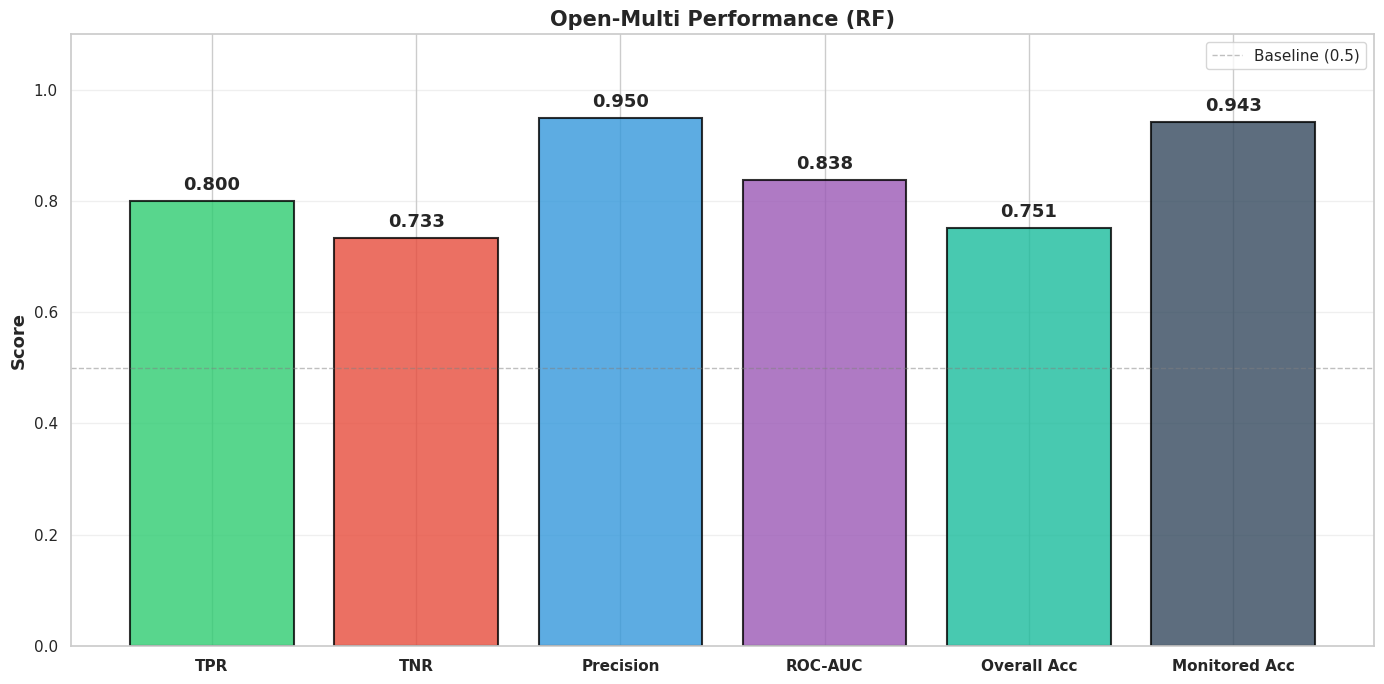


[3/7] Plotting Confusion Matrix...


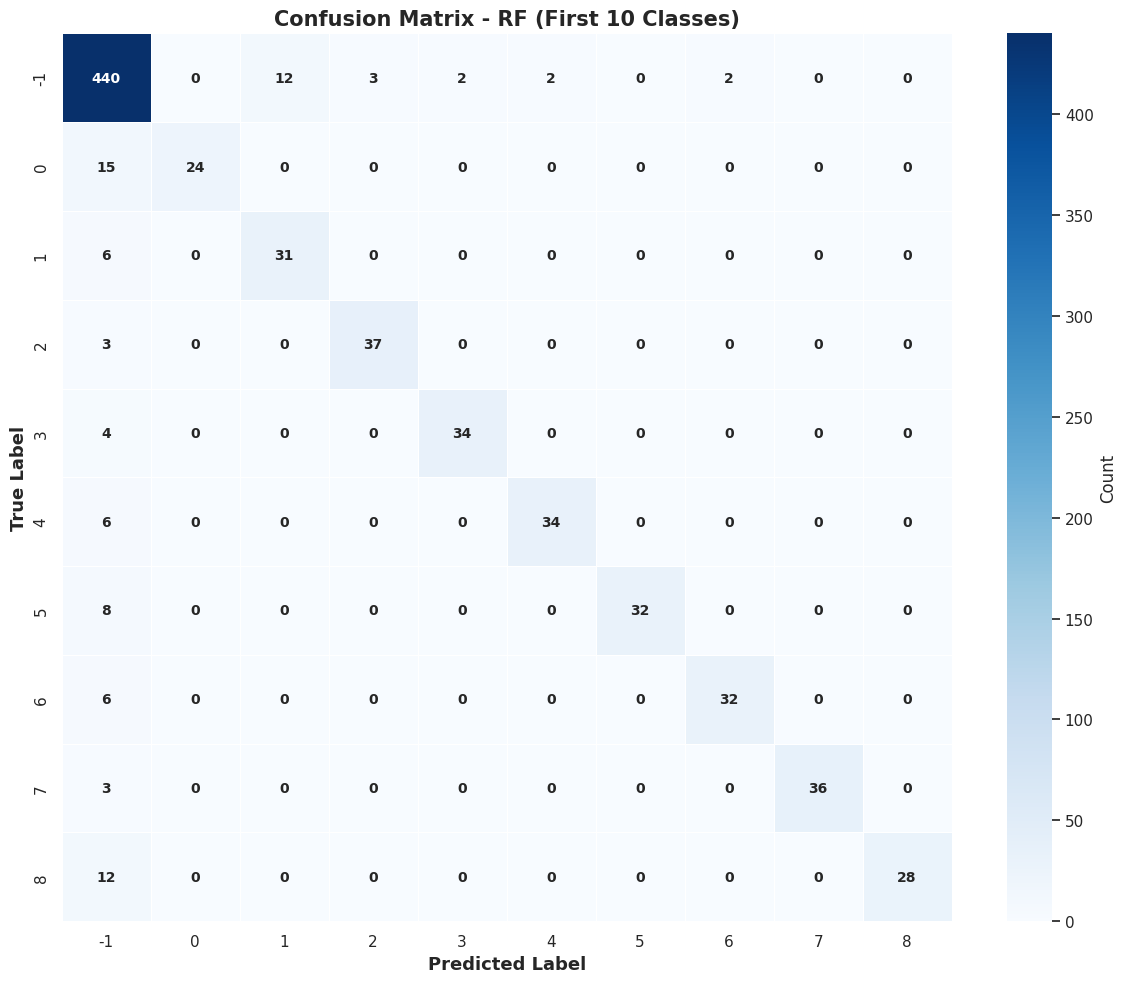


[4/7] Plotting ROC & PR Curves...


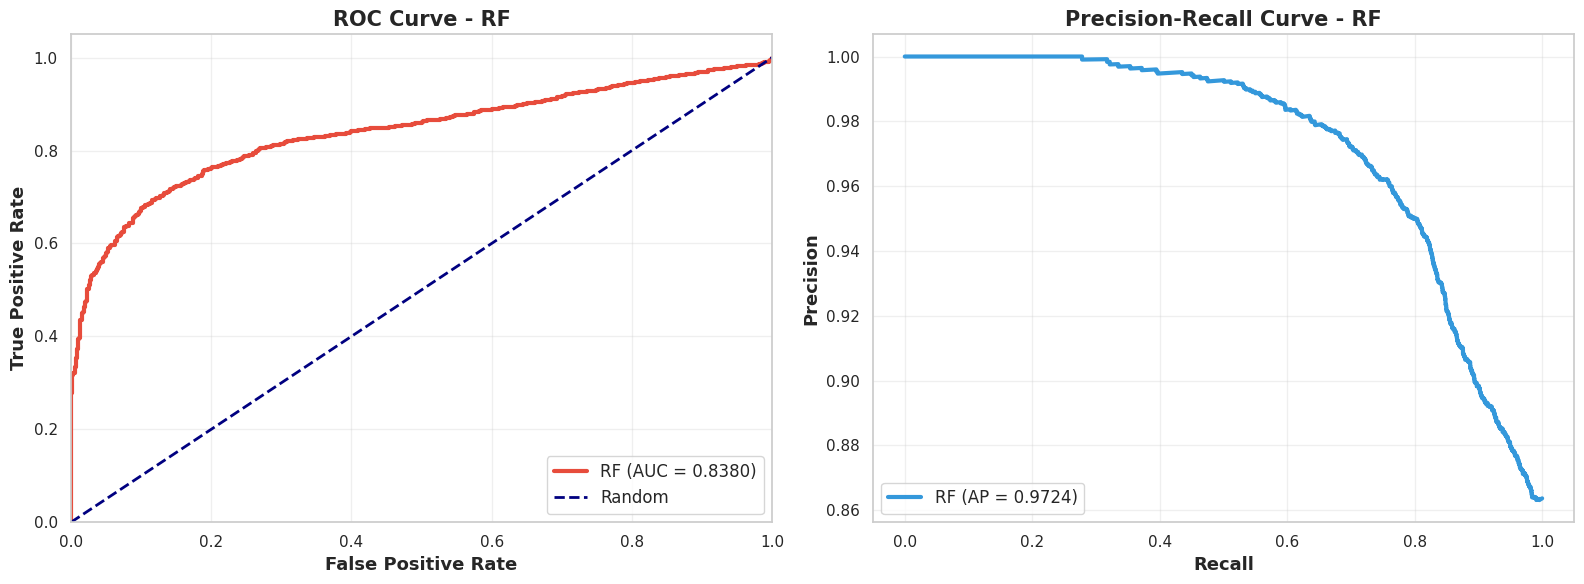


[5/7] Plotting Feature Importance...


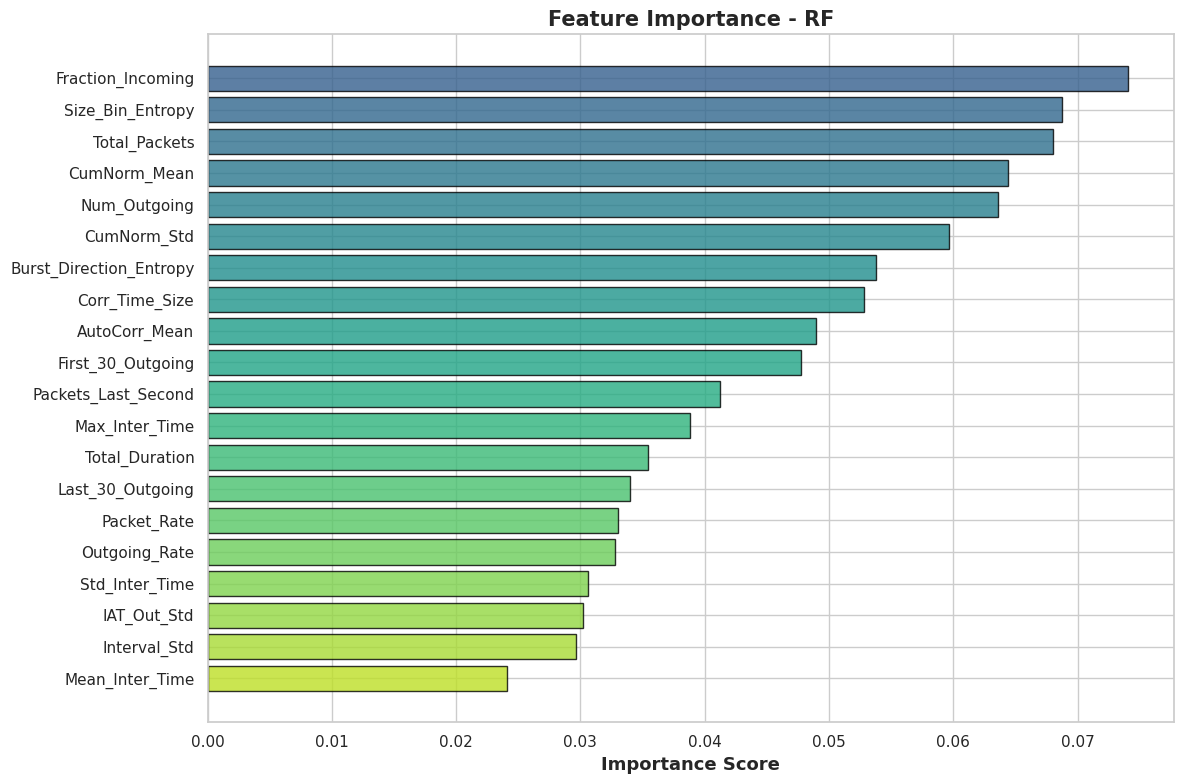


[6/7] Plotting Performance Comparison...


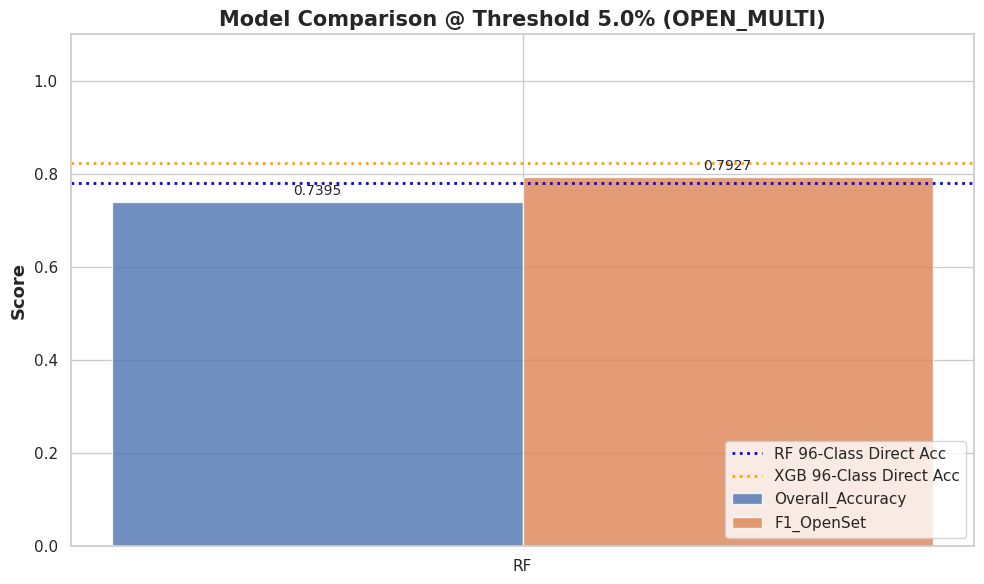


[7/7] Plotting SOTA Comparison...


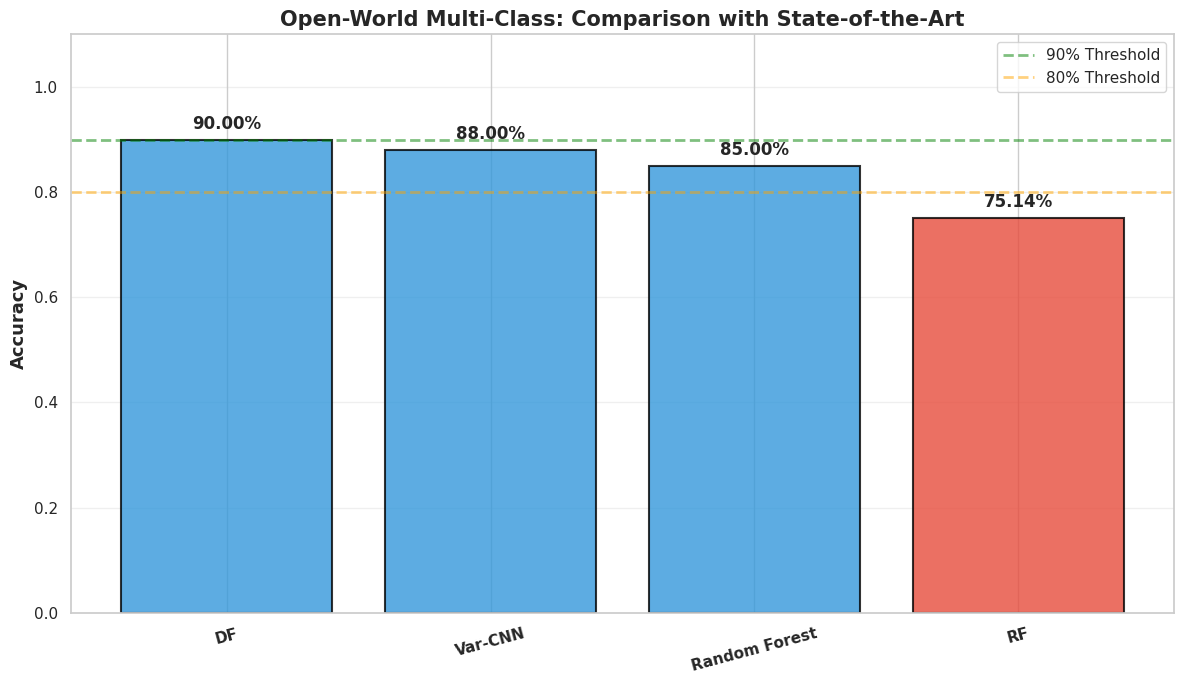

In [29]:
## CLOSED WORLD 시각화
if SCENARIO == 'closed' and 'FINAL_CLOSED_MODEL' in globals():
    print("\n[1/6] Preparing Closed-World Model...")
    model_viz, prep_viz, X_test_viz, y_test_viz, pred_viz, proba_viz = prepare_model_for_viz(
        SCENARIO, FINAL_CLOSED_MODEL, FINAL_CLOSED_CORR
    )

    print("\n[2/6] Plotting Performance Metrics...")
    metrics_dict = {
        'Accuracy': FINAL_CLOSED_ACC,
        'Precision': precision_score(y_test_viz, pred_viz, average='macro', zero_division=0),
        'Recall': recall_score(y_test_viz, pred_viz, average='macro', zero_division=0),
        'F1-Score': f1_score(y_test_viz, pred_viz, average='macro', zero_division=0)
    }
    plot_performance_metrics_bar(metrics_dict,
                                 f'Closed-World Performance ({FINAL_CLOSED_MODEL})')

    print("\n[3/6] Plotting Confusion Matrix...")
    unique_labels = np.unique(y_test_viz)
    plot_confusion_matrix_viz(y_test_viz, pred_viz, unique_labels,
                             f'Confusion Matrix - {FINAL_CLOSED_MODEL}')

    print("\n[4/6] Plotting Feature Importance...")
    plot_feature_importance_viz(model_viz, prep_viz.feature_names,
                                f'Feature Importance - {FINAL_CLOSED_MODEL}')

    print("\n[5/6] Plotting Model Comparison...")
    if 'df_closed' in globals():
        plot_model_comparison(df_closed, FINAL_CLOSED_CORR, 'Closed-World')

    print("\n[6/6] Plotting SOTA Comparison...")
    plot_sota_comparison('closed', FINAL_CLOSED_ACC, FINAL_CLOSED_MODEL)



## OPEN BINARY 시각화
elif SCENARIO == 'open_binary' and 'FINAL_BINARY_MODEL' in globals():
    print("\n[1/7] Preparing Open-Binary Model...")
    model_viz, prep_viz, X_test_viz, y_test_viz, pred_viz, proba_viz = prepare_model_for_viz(
        SCENARIO, FINAL_BINARY_MODEL, FINAL_BINARY_CORR
    )

    print("\n[2/7] Plotting Performance Metrics...")
    best_binary = df_binary[
        (df_binary['Model'] == FINAL_BINARY_MODEL) &
        (df_binary['Corr_Th'] == FINAL_BINARY_CORR)
    ].iloc[0]

    metrics_dict = {
        'TPR': best_binary['TPR'],
        'TNR': best_binary['TNR'],
        'Precision': best_binary['Precision'],
        'ROC-AUC': best_binary['ROC_AUC'],
        'Overall Acc': best_binary['overall_acc']
    }
    plot_performance_metrics_bar(metrics_dict,
                                 f'Open-Binary Performance ({FINAL_BINARY_MODEL})')

    print("\n[3/7] Plotting Confusion Matrix...")
    unique_labels = np.unique(y_test_viz)
    plot_confusion_matrix_viz(y_test_viz, pred_viz, unique_labels,
                             f'Confusion Matrix - {FINAL_BINARY_MODEL}')

    print("\n[4/7] Plotting ROC & PR Curves...")
    y_scores = proba_viz[:, 1] if proba_viz.shape[1] == 2 else proba_viz[:, 0]
    plot_roc_pr_viz(y_test_viz, y_scores, -1, FINAL_BINARY_MODEL)

    print("\n[5/7] Plotting Feature Importance...")
    plot_feature_importance_viz(model_viz, prep_viz.feature_names,
                                f'Feature Importance - {FINAL_BINARY_MODEL}')

    print("\n[6/7] Plotting Model Comparison...")
    if 'df_binary' in globals():
        plot_model_comparison(df_binary, FINAL_BINARY_CORR, 'Open-Binary')

    print("\n[7/7] Plotting SOTA Comparison...")
    plot_sota_comparison('open_binary', best_binary['overall_acc'], FINAL_BINARY_MODEL)


## OPEN MULTI 시각화
# Open-Multi Visualization
elif SCENARIO == 'open_multi' and 'FINAL_MULTI_MODEL' in globals():
    print("\n[1/7] Preparing Open-Multi Model...")
    model_viz, prep_viz, X_test_viz, y_test_viz, pred_viz, proba_viz = prepare_model_for_viz(
        SCENARIO, FINAL_MULTI_MODEL, FINAL_MULTI_CORR, FINAL_MULTI_THRESHOLD
    )

    print("\n[2/7] Plotting Performance Metrics...")
    best_multi = df_open[
        (df_open['Model'] == FINAL_MULTI_MODEL) &
        (df_open['Corr_Threshold'] == FINAL_MULTI_CORR) &
        (df_open['Threshold_Percentile'] == FINAL_MULTI_THRESHOLD)
    ].iloc[0]

    metrics_dict = {
        'TPR': best_multi['TPR'],
        'TNR': best_multi['TNR'],
        'Precision': best_multi['Precision'],
        'ROC-AUC': best_multi['ROC_AUC'],
        'Overall Acc': best_multi['Overall_Accuracy'],
        'Monitored Acc': best_multi['monitored_acc']
    }
    plot_performance_metrics_bar(metrics_dict,
                                 f'Open-Multi Performance ({FINAL_MULTI_MODEL})')

    print("\n[3/7] Plotting Confusion Matrix...")
    unique_labels = np.unique(y_test_viz)
    plot_confusion_matrix_viz(y_test_viz, pred_viz, unique_labels,
                             f'Confusion Matrix - {FINAL_MULTI_MODEL}')

    print("\n[4/7] Plotting ROC & PR Curves...")
    y_scores = np.max(proba_viz, axis=1)
    plot_roc_pr_viz(y_test_viz, y_scores, CURRENT_CONFIG['unmon_label'],
                   FINAL_MULTI_MODEL)

    print("\n[5/7] Plotting Feature Importance...")
    plot_feature_importance_viz(model_viz, prep_viz.feature_names,
                                f'Feature Importance - {FINAL_MULTI_MODEL}')

    print("\n[6/7] Plotting Performance Comparison...")
    if 'df_open' in globals() and 'df_96class' in globals():
        plot_performance_comparison_bar(df_open, df_96class)

    print("\n[7/7] Plotting SOTA Comparison...")
    plot_sota_comparison('open_multi', best_multi['Overall_Accuracy'],
                        FINAL_MULTI_MODEL)